In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

from oceantracker.post_processing.read_output_files.load_output_files import load_particle_track_vars
from oceantracker.post_processing.read_output_files.load_output_files import load_grid

from oceantracker.post_processing.read_output_files.load_output_files import get_case_info_files_from_dir

import seaborn as sns

In [2]:
path_to_case = '/scratch/local1/output/22_12_08_flush_time_v00/22_12_08_flush_time_v02_caseInfo.json'
path_to_case_dir = '/scratch/local1/output/22_12_08_flush_time_v03'

## getting the outline of the estuary \wo north sea

In [6]:
grid = load_grid(path_to_case)

Exception: Cannot find json file "/scratch/local1/output/22_12_08_flush_time_v00/22_12_08_flush_time_v02_caseInfo.json"  

In [ ]:
outlint = grid['grid_outline']['domain']['points']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
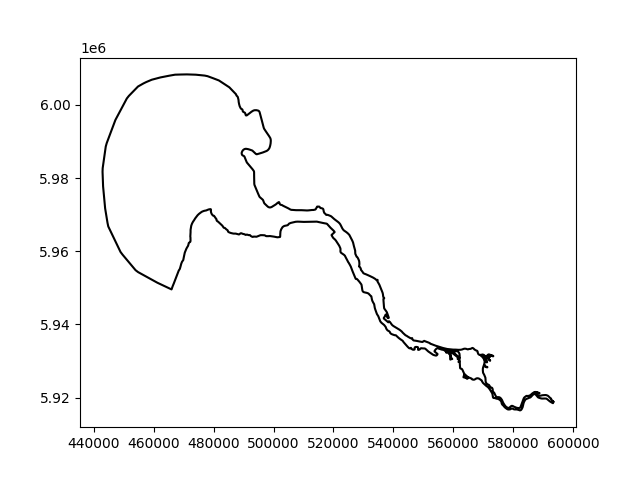

In [ ]:
%matplotlib widget
plt.plot(outlint[:,0], outlint[:,1], 'k')


In [ ]:
links = [4.787e5,5.9709e6]
rechts = [4.890e5,5.9867e6]

# find the point in outline closest to links
dist = np.sqrt((outlint[:,0]-links[0])**2 + (outlint[:,1]-links[1])**2)
idx_links = np.argmin(dist)
# and rechts
dist = np.sqrt((outlint[:,0]-rechts[0])**2 + (outlint[:,1]-rechts[1])**2)
idx_rechts = np.argmin(dist)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
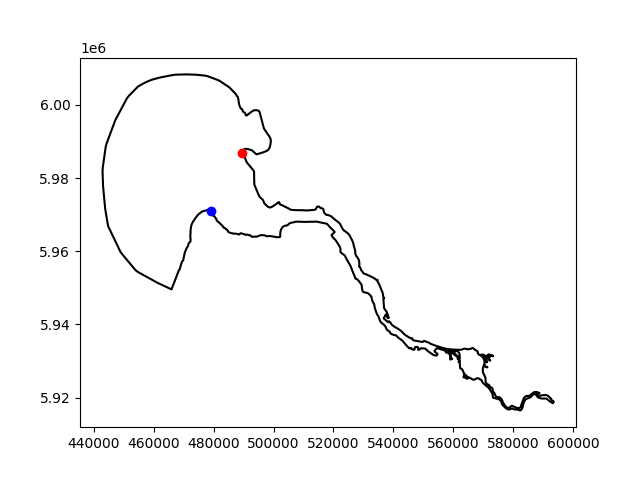

In [ ]:
plt.figure()
ii = 0
plt.plot(outlint[:,0], outlint[:,1], 'k')
# plot idx_rechts
plt.plot(outlint[idx_rechts,0], outlint[idx_rechts,1], 'ro')
# plot idx_links
plt.plot(outlint[idx_links,0], outlint[idx_links,1], 'bo')


In [ ]:
# outline without points between idx_links and idx_rechts
outlint_cut = np.concatenate((outlint[idx_links:,:], outlint[:idx_rechts,:]), axis=0)

2989

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
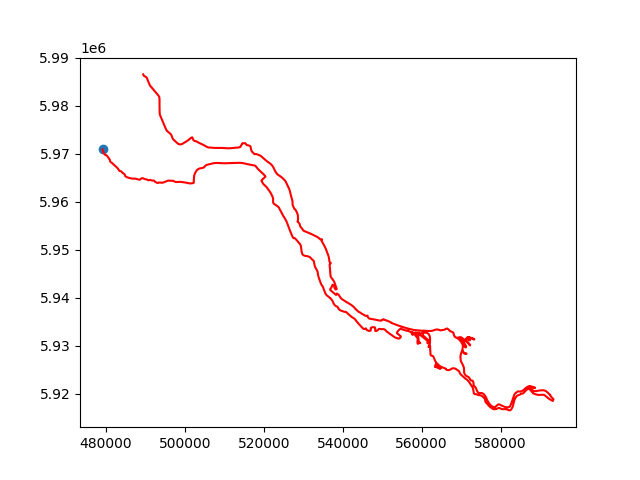

In [ ]:
plt.figure()
plt.plot(outlint_cut[:,0], outlint_cut[:,1], 'r')
plt.scatter(outlint_cut[0,0], outlint_cut[0,1])

'[[ 479102.6875 , 5970917.     ],\n [ 479143.8125 , 5970722.     ],\n [ 479200.59375, 5970530.     ],\n ...,\n [ 489805.59375, 5986125.     ],\n [ 489550.59375, 5986272.     ],\n [ 489411.8125 , 5986536.     ]]'

In [ ]:
def array_to_string(arr):
    lines = ["array(["]
    for row in arr:
        line = ", ".join(map(str, row))
        lines.append(f"    [{line}],")
    lines.append("])")
    return "\n".join(lines)

array_str = array_to_string(outlint_cut)

with open('array_file.txt', 'w') as file:
    file.write(array_str)


## calculate flush-time



In [3]:
cases = get_case_info_files_from_dir(path_to_case_dir)

In [ ]:
tracks = load_particle_track_vars(cases[0],var_list=['water_salinity'])

In [4]:
def find_first_alive_index(status):
    m, n = status.shape

    first_negative_time_steps = np.full(n, -1)  # Fill with -1 to indicate particles that never go negative

    # Iterate over each particle
    for j in range(n):
    # Find the first index where the condition is met
        index = np.where(status[:, j] > 0)[0]
        if index.size > 0:
            first_negative_time_steps[j] = index[0]
    
    return first_negative_time_steps


def find_first_dead_index(status):
    m, n = status.shape

    first_negative_time_steps = np.full(n, -1)  # Fill with -1 to indicate particles that never go negative

    # Iterate over each particle
    for j in range(n):
    # Find the first index where the condition is met
        index = np.where(status[:, j] < 0)[0]
        if index.size > 0:
            first_negative_time_steps[j] = index[0]
    
    return first_negative_time_steps

In [ ]:
flush = {}

release_months = ['Jan', 'Jun']



# winter
for month in release_months:

    flush[month] = {}
    flush[month]['origin'] = np.empty((0,2))
    flush[month]['time_alive'] = np.empty((0))

    if month == 'Jan':
        case_min = 0
        case_max = 100
    elif month == 'Jun':
        case_min = 100
        case_max = 200

    for ii in range(case_min, case_max):
        print(ii)

        tracks = load_particle_track_vars(cases[ii],var_list=['water_salinity'])
        
        idx_release = find_first_alive_index(tracks['status'])
        idx_last = find_first_dead_index(tracks['status'])

        salinity = np.empty((idx_last.size))
        for ii,idx in enumerate(idx_last):
            salinity[ii] = tracks['water_salinity'][idx,ii]


        origin = np.empty((idx_release.size,2))
        for ii,idx in enumerate(idx_release):
            origin[ii,:] = tracks['x'][idx,ii,:2]

        # get the time alive
        time_alive = tracks['time'][idx_last] - tracks['time'][idx_release]
        # time_alive in days

        # slice particles to only include particles that died in salinities above 19
        origin = origin[salinity > 19]
        time_alive = time_alive[salinity > 19]

        flush[month]['origin'] = np.concatenate((flush[month]['origin'], origin), axis=0)
        flush[month]['time_alive'] = np.concatenate((flush[month]['time_alive'], time_alive), axis=0)


with open('flush_time.pickle', 'wb') as handle:
    pickle.dump(flush, handle, protocol=pickle.HIGHEST_PROTOCOL)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [5]:
# read flush from pickle

with open('flush_time.pickle', 'rb') as handle:
    flush = pickle.load(handle)

In [ ]:
flush['Jan']['origin'].shape

(892591, 2)

In [6]:

# x = flush['Jan']['origin'][:,0]
# y = flush['Jan']['origin'][:,1]
# age =  flush['Jan']['time_alive']

# concate

x = np.concatenate((flush['Jan']['origin'][:,0],flush['Jun']['origin'][:,0]), axis=0)
y = np.concatenate((flush['Jan']['origin'][:,1],flush['Jun']['origin'][:,1]), axis=0)
age = np.concatenate((flush['Jan']['time_alive'],flush['Jun']['time_alive']), axis=0)



In [17]:


def plot_hexbin_flushtime(x, y, age, age_bins=25, space_bins=30, color_scheme='viridis'):

    def rotate_points(x, y, label, angle, point):

        x_rotated = (x - point[0]) * np.cos(angle) - (y - point[1]) * np.sin(angle) + point[0]
        y_rotated = (x - point[0]) * np.sin(angle) + (y - point[1]) * np.cos(angle) + point[1]

        for key, value in label.items():
            x_rotated_label = (value[0] - point[0]) * np.cos(angle) - (value[1] - point[1]) * np.sin(angle) + point[0]
            y_rotated_label = (value[0] - point[0]) * np.sin(angle) + (value[1] - point[1]) * np.cos(angle) + point[1]
            label[key] = [x_rotated_label, y_rotated_label]


        return x_rotated, y_rotated, label



    # [5.489e5,5.9312e6] # mühlenberger loch
    # [5,403e5,5.9457e6] # haseldorfer binnenelbe

    # [5.471e5,5.9383e6] # wedeler marsch
    # [5.197e5,5.9619e6] # wischhafen
    # [5.319e5,5.9639e6] # stoer
    # [5.290e5,5.9490e6] # schwarztonnensand/ ruth
    # [5.0918e5,5.96746e6] # nordkedding
    # [5.025e5, 5.9737e6] # neufelder marsch

    labels = ['a', 'c', 'b', 'f', 'e', 'd', 'g', 'h']
    x_coords = [5.489e5, 5.383e5, 5.440e5, 5.197e5, 5.270e5, 5.290e5, 5.080e5, 5.025e5]
    y_coords = [5.9312e6, 5.9457e6, 5.9383e6, 5.9619e6, 5.9639e6, 5.9480e6, 5.9665e6, 5.9730e6]

    labels_dict = {}
    for label, x_coord, y_coord in zip(labels, x_coords, y_coords):
        labels_dict[label] = [x_coord, y_coord]



    x, y, labels_rotated = rotate_points(x, y, labels_dict, 32 * np.pi / 180, [5.489e5,5.9312e6])

    print(x.shape)

    # same for age
    age = age.flatten()
    age = age[~np.isnan(age)]
    # transform age from seconds to days
    age = age / (60*60*24)

    # define axis limits with fixes aspect ratio
    xlim = [4.80e5, 5.75e5]
    ylim = [5.924e6, 5.950e6]


    # select those in between axis limits
    in_window = np.logical_and(x >= xlim[0], x <= xlim[1])
    in_window = np.logical_and(in_window, y >= ylim[0])
    in_window = np.logical_and(in_window, y <= ylim[1])

    x = x[in_window]
    y = y[in_window]
    age = age[in_window]

    aspect_ratio = (np.max(x) - np.min(x)) / (np.max(y) - np.min(y))



    # -- BINNING --

    # Define the number of bins
    num_bins = 30

    # Create a 2D histogram with hexagonal bins
    cmap = cm.get_cmap(color_scheme, age_bins)
    # use an inverse inferno colormap
    # cmap = cmap.reversed()

    # -- PLOTTING --

    # 12cm in width
    fig,ax = plt.subplots(figsize=(12 , 12/(aspect_ratio*0.85)), dpi=300)
    ax.set_facecolor('lightgray')


    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    hb = ax.hexbin(x, y, C=age, reduce_C_function=np.mean,
                gridsize=[int(num_bins*aspect_ratio),num_bins], cmap=cmap, vmin=0, vmax=25,
                extent=[xlim[0], xlim[1], ylim[0], ylim[1]], zorder=3)
    cb = fig.colorbar(hb, ax=ax, label='average age (days)',pad=0.01)

    # add an arrow pointing 32 degree north in the top center
    arrow_pos = [0.95, 0.1]
    ax.arrow(arrow_pos[0],arrow_pos[1], -np.sin(32 * np.pi / 180)*0.15, np.cos(32 * np.pi / 180)*0.15, 
            transform=ax.transAxes, length_includes_head=True, overhang=0.3,
            head_width=0.03, head_length=0.04, color='k', zorder=4)

    # add N to arrow
    ax.text(arrow_pos[0]+0.015,arrow_pos[1]-0.07, 'N', transform=ax.transAxes, fontsize=14, zorder=4)

    # add labels
    # for key, value in labels_rotated.items():
    #     ax.text(value[0], value[1], key, ha='center', va='center', zorder=4, fontsize=14)

    # fix aspect ratio
    ax.set_aspect('equal', 'box')

    # add a north pointing arrow turned by 32 degree



    plt.tight_layout()
    # plt.show()
    # plt.savefig('age_hexbin.png', dpi=300, bbox_inches='tight')

    return fig, ax


(1780774,)


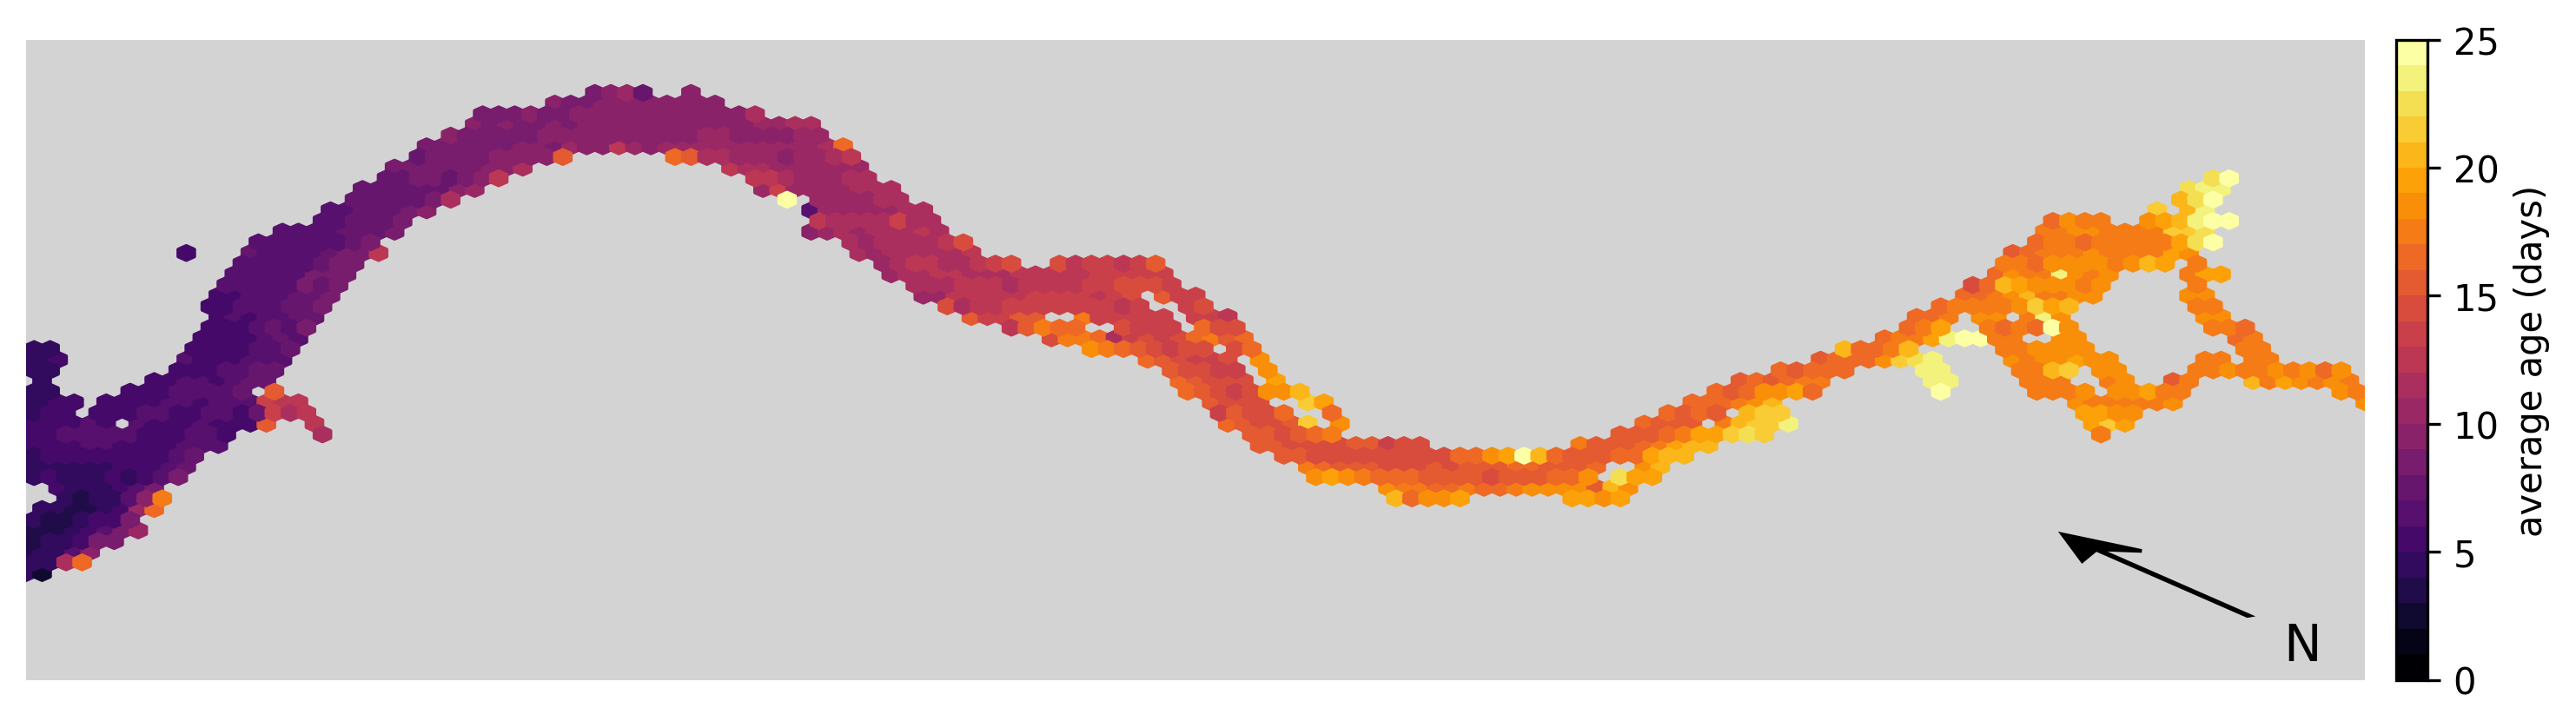

In [20]:
fig,ax = plot_hexbin_flushtime(x, y, age, age_bins=25, space_bins=30, color_scheme='inferno')
# savefig
plt.savefig('flush_hexbin.png', dpi=300, bbox_inches='tight')